/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/stormeunice/lagrangian.py:153: FutureWarning: Following pandas, the `base` parameter to resample will be deprecated in a future version of xarray.  Switch to using `origin` or `offset` instead.
  mxtpr_field_out = mem_fields.mxtpr.sel(time=slice(time_start, time_end)).resample(time='{}h'.format(resample_freq), label='right', closed='right', base=0).max()
/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/stormeunice/lagrangian.py:179: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date', 'experiment', 'inidate'], dtype='object')
  peak_vo = mem_track.rolling(3, center=True).mean().vo.idxmax()
/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/stormeunice/lagrangian.py:153: FutureWarning:

Text(74.0, 0.5, 'lat from storm centre')

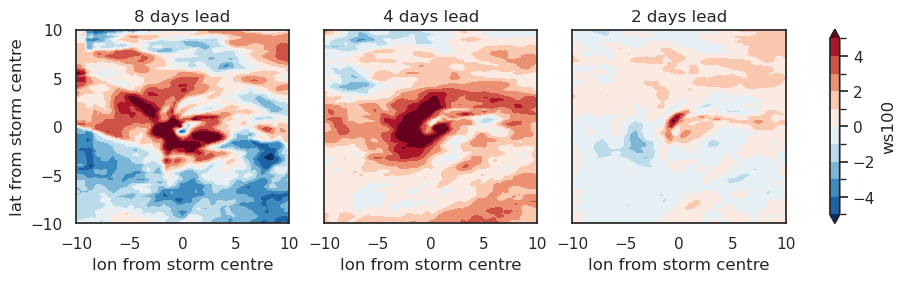

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cp
import stormeunice as eun
import multiprocessing
import glob
import dask

sys.path.append('/home/e/ermis/moarpalettes')
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")
%matplotlib inline

random.seed(10)

#Data import and pre-processing

# Import track data
P1 = multiprocessing.Pool(40)
ifs_tracks = P1.map(eun.lagrangian.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))
P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

# add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',
                        skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min)).iloc[0]

# starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
# starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

# For members with more than one Eunice-like track: keep the ones with the longest track? 
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: eun.lagrangian.Lagrange.eunice_dist(x,eunice_track=eunice_track))
    num_reject = track_dists.idxmax()
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)

# capture 
# Ignore outputs

# Import field data, Lagrangian fram
curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe(x, ifs_eunice_list=ifs_eunice_list),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

#Surface Lagrangians
#Wind speeds

cplot = (incr_storms.ws100.sel(timestep=0).mean('number').squeeze() - pi_storms.ws100.sel(timestep=0).mean('number').squeeze()).sortby('inidate').plot.contourf(col='inidate',levels=np.linspace(-5,5,11))

cplot.axes[0,0].set_title('8 days lead')
cplot.axes[0,1].set_title('4 days lead')
cplot.axes[0,2].set_title('2 days lead')

cplot.axes[0,0].set_xlabel('lon from storm centre')
cplot.axes[0,1].set_xlabel('lon from storm centre')
cplot.axes[0,2].set_xlabel('lon from storm centre')
cplot.axes[0,0].set_ylabel('lat from storm centre')



In [5]:
ifs_eunice_list

,track_id,inidate,experiment,number,year,month,day,hour,i,j,lon,lat,msl,vo,expid,date
0,1,2022-02-14,ENS,25,2022,2,17,9,0,111,-27.00,45.75,100150.40,0.000130,1,2022-02-17 09:00:00
1,1,2022-02-14,ENS,25,2022,2,17,12,1,108,-26.75,46.50,99387.10,0.000238,1,2022-02-17 12:00:00
2,1,2022-02-14,ENS,25,2022,2,17,15,10,105,-24.50,47.25,99108.85,0.000457,1,2022-02-17 15:00:00
3,1,2022-02-14,ENS,25,2022,2,17,18,21,99,-21.75,48.75,98643.55,0.000504,1,2022-02-17 18:00:00
4,1,2022-02-14,ENS,25,2022,2,17,21,30,95,-19.50,49.75,97933.05,0.000611,1,2022-02-17 21:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,8,2022-02-10,pi,26,2022,2,19,0,87,40,-5.25,63.50,97509.29,0.000323,b2nq,2022-02-19 00:00:00
5102,8,2022-02-10,pi,26,2022,2,19,6,88,36,-5.00,64.50,97837.22,0.000289,b2nq,2022-02-19 06:00:00
5103,8,2022-02-10,pi,26,2022,2,19,12,96,33,-3.00,65.25,98208.47,0.000314,b2nq,2022-02-19 12:00:00
5104,8,2022-02-10,pi,26,2022,2,19,18,98,27,-2.50,66.75,98565.02,0.000297,b2nq,2022-02-19 18:00:00
